# Task 3: Interactive Dashboard Design

## Assignment: Data Visualization and Story Telling (5 Marks)

This notebook creates an **interactive dashboard** that integrates all visualizations from Task 2, providing a comprehensive view of voter turnout data across 10 parliamentary constituencies (2014, 2019, 2024).

### Dashboard Components:
1. **KPI Summary Cards** - Key metrics at a glance
2. **Temporal Trend Line** - Voter turnout over time
3. **Gender Comparison** - Male vs Female vs Third Gender
4. **Constituency Heatmap** - Distribution across regions and years
5. **Interactive Controls** - Filters for exploration

### Libraries Used:
- **Bokeh** - Interactive dashboard with widgets
- **Panel** - Dashboard layout framework (alternative: pure Bokeh)
- **Matplotlib/Seaborn** - Static visualizations embedded in dashboard

## 1. Import Libraries and Load Data

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import (ColumnDataSource, HoverTool, Div, Select, 
                          CustomJS, Panel, Tabs, Legend, LegendItem)
from bokeh.layouts import column, row, gridplot
from bokeh.palettes import Category10, Viridis256, RdYlGn
from bokeh.transform import factor_cmap, cumsum
from bokeh.io import curdoc
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Enable Bokeh output in notebook
output_notebook()

# Set matplotlib style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("✅ Libraries imported successfully!")

Loading BokehJS ...

✅ Libraries imported successfully!


In [2]:
# Load the curated dataset
df = pd.read_csv('cleaned_data/curated_voter_turnout_10_constituencies.csv')

# Display dataset info
print("📊 Dataset loaded successfully!")
print(f"   Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"   Constituencies: {df['PC_Name'].nunique()}")
print(f"   Years: {sorted(df['Year'].unique())}")
df.head(3)

📊 Dataset loaded successfully!
   Shape: 30 rows × 18 columns
   Constituencies: 10
   Years: [np.int64(2014), np.int64(2019), np.int64(2024)]


,Year,State,PC_Name,Electors_Total,Electors_Male,Electors_Female,Electors_TG,Voters_Male,Voters_Female,Voters_TG,Voters_Total,Postal_Votes,Total_Voters,Turnout_Percent,Turnout_Male,Turnout_Female,Turnout_TG,Turnout_Postal
0,2014,Karnataka,BANGALORE SOUTH,1998724,1050583,947604,320,596688,516207,19,1112914,1445,1114359,55.753521,56.795839,54.474971,5.9375,0.129671
1,2019,Karnataka,BANGALORE SOUTH,2215489,1153492,1061577,344,616311,568793,33,1185137,4520,1189657,53.700000,53.430000,53.580000,9.5900,0.379941
2,2024,Karnataka,BANGALORE SOUTH,2341895,1207404,1134091,400,630756,614381,51,1245188,4864,1250052,53.380000,52.240000,54.170000,12.7500,0.389104


## 2. Dashboard Header with KPI Cards

Key Performance Indicators displayed as summary cards for quick insights.

In [3]:
# Calculate KPI values
avg_turnout_2024 = df[df['Year'] == 2024]['Turnout_Percent'].mean()
avg_turnout_2019 = df[df['Year'] == 2019]['Turnout_Percent'].mean()
avg_turnout_2014 = df[df['Year'] == 2014]['Turnout_Percent'].mean()
overall_avg = df['Turnout_Percent'].mean()

# Calculate changes
change_2024_vs_2019 = avg_turnout_2024 - avg_turnout_2019
change_2019_vs_2014 = avg_turnout_2019 - avg_turnout_2014

# Gender stats
male_avg = df['Turnout_Male'].mean()
female_avg = df['Turnout_Female'].mean()
gender_gap = male_avg - female_avg

# Best and worst performers
best_constituency = df.groupby('PC_Name')['Turnout_Percent'].mean().idxmax()
best_turnout = df.groupby('PC_Name')['Turnout_Percent'].mean().max()
worst_constituency = df.groupby('PC_Name')['Turnout_Percent'].mean().idxmin()
worst_turnout = df.groupby('PC_Name')['Turnout_Percent'].mean().min()

# Create KPI Dashboard Header using HTML Divs
kpi_style = """
<style>
.kpi-container {
    display: flex;
    justify-content: space-around;
    flex-wrap: wrap;
    gap: 15px;
    padding: 20px;
    background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
    border-radius: 15px;
    margin-bottom: 20px;
}
.kpi-card {
    background: white;
    border-radius: 12px;
    padding: 20px 30px;
    text-align: center;
    min-width: 180px;
    box-shadow: 0 4px 15px rgba(0,0,0,0.1);
    transition: transform 0.3s ease;
}
.kpi-card:hover {
    transform: translateY(-5px);
}
.kpi-value {
    font-size: 32px;
    font-weight: bold;
    color: #2E86AB;
    margin: 5px 0;
}
.kpi-label {
    font-size: 12px;
    color: #666;
    text-transform: uppercase;
    letter-spacing: 1px;
}
.kpi-change {
    font-size: 14px;
    margin-top: 5px;
}
.positive { color: #2ca02c; }
.negative { color: #d62728; }
.dashboard-title {
    text-align: center;
    color: white;
    font-size: 28px;
    font-weight: bold;
    margin-bottom: 20px;
    text-shadow: 2px 2px 4px rgba(0,0,0,0.3);
}
</style>
"""

change_icon_2024 = "↑" if change_2024_vs_2019 > 0 else "↓"
change_class_2024 = "positive" if change_2024_vs_2019 > 0 else "negative"

kpi_html = f"""
{kpi_style}
<div class="dashboard-title">📊 Voter Turnout Dashboard - India Elections (2014-2024)</div>
<div class="kpi-container">
    <div class="kpi-card">
        <div class="kpi-label">2024 Avg Turnout</div>
        <div class="kpi-value">{avg_turnout_2024:.1f}%</div>
        <div class="kpi-change {change_class_2024}">{change_icon_2024} {abs(change_2024_vs_2019):.1f}% vs 2019</div>
    </div>
    <div class="kpi-card">
        <div class="kpi-label">Overall Average</div>
        <div class="kpi-value">{overall_avg:.1f}%</div>
        <div class="kpi-change">Across all years</div>
    </div>
    <div class="kpi-card">
        <div class="kpi-label">Gender Gap</div>
        <div class="kpi-value">{abs(gender_gap):.1f}%</div>
        <div class="kpi-change">Male higher than Female</div>
    </div>
    <div class="kpi-card">
        <div class="kpi-label">Top Performer</div>
        <div class="kpi-value" style="font-size:18px;">{best_constituency}</div>
        <div class="kpi-change positive">{best_turnout:.1f}% avg</div>
    </div>
    <div class="kpi-card">
        <div class="kpi-label">Needs Attention</div>
        <div class="kpi-value" style="font-size:18px;">{worst_constituency}</div>
        <div class="kpi-change negative">{worst_turnout:.1f}% avg</div>
    </div>
</div>
"""

# Display KPI header
kpi_header = Div(text=kpi_html, width=1000, height=250)
show(kpi_header)

## 3. Interactive Dashboard - Multi-Panel Layout

This section creates an integrated dashboard with multiple visualizations arranged in a grid layout.

In [4]:
# ============================================================
# Panel 1: Voter Turnout Trend Over Time (Line Chart)
# ============================================================

# Prepare data for line chart
yearly_data = df.groupby('Year')['Turnout_Percent'].mean().reset_index()
yearly_data.columns = ['Year', 'Turnout']

# Create source
line_source = ColumnDataSource(data=dict(
    year=yearly_data['Year'].astype(str).tolist(),
    turnout=yearly_data['Turnout'].tolist()
))

# Create line chart
p1 = figure(x_range=yearly_data['Year'].astype(str).tolist(), 
            height=300, width=480,
            title="📈 Voter Turnout Trend Over Time",
            toolbar_location="above",
            tools="pan,wheel_zoom,reset,save")

p1.line(x='year', y='turnout', source=line_source, 
        line_width=4, color='#2E86AB', alpha=0.8)
p1.circle(x='year', y='turnout', source=line_source, 
          size=15, color='#2E86AB', fill_color='white', line_width=3)

# Add hover
hover1 = HoverTool(tooltips=[("Year", "@year"), ("Turnout", "@turnout{0.1}%")])
p1.add_tools(hover1)

# Styling
p1.yaxis.axis_label = "Average Turnout (%)"
p1.xaxis.axis_label = "Election Year"
p1.y_range.start = 50
p1.y_range.end = 70
p1.title.text_font_size = "14pt"
p1.xgrid.grid_line_color = None

print("✅ Panel 1: Trend Line Chart created")

✅ Panel 1: Trend Line Chart created


In [5]:
# ============================================================
# Panel 2: Gender-wise Turnout Comparison (Grouped Bar)
# ============================================================

from bokeh.models import FactorRange

# Prepare gender data
gender_yearly = df.groupby('Year').agg({
    'Turnout_Male': 'mean',
    'Turnout_Female': 'mean'
}).reset_index()

years = [str(y) for y in gender_yearly['Year']]
genders = ['Male', 'Female']

# Create factor range for grouped bars
x = [(year, gender) for year in years for gender in genders]
counts = []
for year in years:
    row = gender_yearly[gender_yearly['Year'] == int(year)]
    counts.append(row['Turnout_Male'].values[0])
    counts.append(row['Turnout_Female'].values[0])

bar_source = ColumnDataSource(data=dict(x=x, counts=counts))

# Create grouped bar chart
p2 = figure(x_range=FactorRange(*x), height=300, width=480,
            title="👥 Gender-wise Voter Turnout",
            toolbar_location="above",
            tools="pan,wheel_zoom,reset,save")

p2.vbar(x='x', top='counts', width=0.8, source=bar_source,
        fill_color=factor_cmap('x', palette=['#1f77b4', '#e377c2'], 
                               factors=genders, start=1, end=2),
        line_color='white', line_width=1.5)

# Add hover
hover2 = HoverTool(tooltips=[("Category", "@x"), ("Turnout", "@counts{0.1}%")])
p2.add_tools(hover2)

# Styling
p2.y_range.start = 0
p2.y_range.end = 75
p2.xgrid.grid_line_color = None
p2.xaxis.major_label_orientation = 0.8
p2.yaxis.axis_label = "Turnout (%)"
p2.title.text_font_size = "14pt"

print("✅ Panel 2: Gender Bar Chart created")

✅ Panel 2: Gender Bar Chart created


In [6]:
# ============================================================
# Panel 3: Constituency Ranking (Horizontal Bar Chart)
# ============================================================

# Prepare constituency data
const_avg = df.groupby('PC_Name')['Turnout_Percent'].mean().sort_values()
const_data = pd.DataFrame({
    'constituency': const_avg.index.tolist(),
    'turnout': const_avg.values.tolist()
})

# Add color based on performance
const_data['color'] = const_data['turnout'].apply(
    lambda x: '#2ca02c' if x >= 60 else ('#f0ad4e' if x >= 50 else '#d9534f')
)

const_source = ColumnDataSource(const_data)

# Create horizontal bar chart
p3 = figure(y_range=const_data['constituency'].tolist(), 
            height=350, width=480,
            title="🏙️ Constituency Ranking by Turnout",
            toolbar_location="above",
            tools="pan,wheel_zoom,reset,save")

p3.hbar(y='constituency', right='turnout', height=0.7, 
        source=const_source, color='color', line_color='white')

# Add hover
hover3 = HoverTool(tooltips=[
    ("Constituency", "@constituency"),
    ("Avg Turnout", "@turnout{0.1}%")
])
p3.add_tools(hover3)

# Styling
p3.x_range.start = 0
p3.x_range.end = 80
p3.xaxis.axis_label = "Average Turnout (%)"
p3.ygrid.grid_line_color = None
p3.title.text_font_size = "14pt"

print("✅ Panel 3: Constituency Ranking created")

✅ Panel 3: Constituency Ranking created


In [7]:
# ============================================================
# Panel 4: Year-over-Year Change (Bullet/Bar Chart)
# ============================================================

# Calculate year-over-year changes for each constituency
pivot_data = df.pivot(index='PC_Name', columns='Year', values='Turnout_Percent')
pivot_data['Change_2019_2014'] = pivot_data[2019] - pivot_data[2014]
pivot_data['Change_2024_2019'] = pivot_data[2024] - pivot_data[2019]
pivot_data = pivot_data.reset_index()

# Prepare data for visualization
change_data = pd.DataFrame({
    'constituency': pivot_data['PC_Name'].tolist(),
    'change_2024': pivot_data['Change_2024_2019'].tolist(),
    'turnout_2024': pivot_data[2024].tolist()
})
change_data = change_data.sort_values('change_2024')
change_data['color'] = change_data['change_2024'].apply(
    lambda x: '#2ca02c' if x > 0 else '#d9534f'
)

change_source = ColumnDataSource(change_data)

# Create change bar chart
p4 = figure(y_range=change_data['constituency'].tolist(),
            height=350, width=480,
            title="📊 Change in Turnout (2024 vs 2019)",
            toolbar_location="above",
            tools="pan,wheel_zoom,reset,save")

p4.hbar(y='constituency', right='change_2024', height=0.7,
        source=change_source, color='color', line_color='white')

# Add zero line
p4.line([0, 0], [-1, 10], line_width=2, color='gray', line_dash='dashed')

# Add hover
hover4 = HoverTool(tooltips=[
    ("Constituency", "@constituency"),
    ("Change", "@change_2024{+0.1}%"),
    ("2024 Turnout", "@turnout_2024{0.1}%")
])
p4.add_tools(hover4)

# Styling
p4.xaxis.axis_label = "Change in Turnout (%)"
p4.ygrid.grid_line_color = None
p4.title.text_font_size = "14pt"

print("✅ Panel 4: Year-over-Year Change chart created")

✅ Panel 4: Year-over-Year Change chart created


## 4. Assemble the Complete Dashboard

Combining all panels into a unified, interactive dashboard layout.

In [8]:
# ============================================================
# Assemble Dashboard with Grid Layout
# ============================================================

# Create section headers
header_style = """
<div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); 
            padding: 15px; border-radius: 10px; margin: 10px 0;">
    <h2 style="color: white; margin: 0; text-align: center;">
        📊 Voter Turnout Analysis Dashboard - India General Elections
    </h2>
    <p style="color: #e0e0e0; text-align: center; margin: 5px 0;">
        Analyzing voter participation across 10 constituencies (2014, 2019, 2024)
    </p>
</div>
"""

insights_html = """
<div style="background: #f8f9fa; padding: 15px; border-radius: 10px; margin: 10px 0; border-left: 4px solid #2E86AB;">
    <h3 style="color: #333; margin: 0 0 10px 0;">💡 Key Insights</h3>
    <ul style="color: #555; margin: 0; padding-left: 20px;">
        <li><strong>Declining Trend:</strong> Voter turnout has decreased from 59.6% (2014) to 56.8% (2024)</li>
        <li><strong>Gender Gap:</strong> Male voters consistently show ~3% higher turnout than females</li>
        <li><strong>Regional Variation:</strong> Chandigarh leads with 70.8% while Patna Sahib trails at 46.0%</li>
        <li><strong>2024 Impact:</strong> Most constituencies saw a decline compared to 2019</li>
    </ul>
</div>
"""

header_div = Div(text=header_style, width=980)
insights_div = Div(text=insights_html, width=980)

# Create the dashboard grid
dashboard_grid = gridplot(
    [[p1, p2], 
     [p3, p4]],
    merge_tools=True,
    toolbar_location="above"
)

# Assemble full dashboard
full_dashboard = column(header_div, dashboard_grid, insights_div)

# Display the dashboard
show(full_dashboard)

print("\n" + "="*60)
print("🎉 INTERACTIVE DASHBOARD CREATED SUCCESSFULLY!")
print("="*60)
print("\n📌 Dashboard Features:")
print("   • Pan & zoom on any chart")
print("   • Hover over data points for details")
print("   • Reset view with reset button")
print("   • Save chart as PNG")


🎉 INTERACTIVE DASHBOARD CREATED SUCCESSFULLY!

📌 Dashboard Features:
   • Pan & zoom on any chart
   • Hover over data points for details
   • Reset view with reset button
   • Save chart as PNG


## 5. Interactive Drill-Down Feature - Constituency Selector

This section implements the **drill-down/selection feature** as required by the assignment. Users can select a specific constituency from a dropdown to view detailed information.

In [9]:
# ============================================================
# DRILL-DOWN FEATURE: Interactive Constituency Selector
# ============================================================

from bokeh.models import Select, CustomJS, DataTable, TableColumn, StringFormatter
from bokeh.layouts import column, row

# Prepare constituency-specific data for drill-down
constituencies = sorted(df['PC_Name'].unique().tolist())

# Create a Select widget for constituency selection
constituency_select = Select(
    title="🔍 Select Constituency for Detailed View:",
    value=constituencies[0],
    options=constituencies,
    width=300
)

# ============================================================
# Create detailed view for selected constituency
# ============================================================

# Initialize with first constituency
initial_const = constituencies[0]
const_data = df[df['PC_Name'] == initial_const].sort_values('Year')

# Create data sources for the detail charts
detail_source = ColumnDataSource(data=dict(
    year=[str(y) for y in const_data['Year']],
    turnout=const_data['Turnout_Percent'].tolist(),
    male=const_data['Turnout_Male'].tolist(),
    female=const_data['Turnout_Female'].tolist(),
    electors=const_data['Electors_Total'].tolist(),
    voters=const_data['Total_Voters'].tolist()
))

# Full data source for JavaScript callback
full_data = {}
for const in constituencies:
    cdata = df[df['PC_Name'] == const].sort_values('Year')
    full_data[const] = {
        'year': [str(y) for y in cdata['Year']],
        'turnout': cdata['Turnout_Percent'].tolist(),
        'male': cdata['Turnout_Male'].tolist(),
        'female': cdata['Turnout_Female'].tolist(),
        'electors': cdata['Electors_Total'].tolist(),
        'voters': cdata['Total_Voters'].tolist()
    }

# ============================================================
# Detail Chart 1: Constituency Turnout Trend
# ============================================================

detail_trend = figure(
    x_range=['2014', '2019', '2024'],
    height=300, width=450,
    title=f"📈 Turnout Trend: {initial_const}",
    toolbar_location="above",
    tools="pan,wheel_zoom,reset,save"
)

detail_trend.line(x='year', y='turnout', source=detail_source,
                  line_width=4, color='#2E86AB')
detail_trend.circle(x='year', y='turnout', source=detail_source,
                    size=12, color='#2E86AB', fill_color='white', line_width=3)

detail_trend.yaxis.axis_label = "Turnout (%)"
detail_trend.y_range.start = 30
detail_trend.y_range.end = 80
detail_trend.xgrid.grid_line_color = None

# Add hover
detail_hover1 = HoverTool(tooltips=[
    ("Year", "@year"),
    ("Turnout", "@turnout{0.1}%")
])
detail_trend.add_tools(detail_hover1)

# ============================================================
# Detail Chart 2: Gender Comparison for Selected Constituency
# ============================================================

detail_gender = figure(
    x_range=['2014', '2019', '2024'],
    height=300, width=450,
    title=f"👥 Gender Comparison: {initial_const}",
    toolbar_location="above",
    tools="pan,wheel_zoom,reset,save"
)

# Male turnout line
detail_gender.line(x='year', y='male', source=detail_source,
                   line_width=3, color='#1f77b4', legend_label='Male')
detail_gender.circle(x='year', y='male', source=detail_source,
                     size=10, color='#1f77b4')

# Female turnout line  
detail_gender.line(x='year', y='female', source=detail_source,
                   line_width=3, color='#e377c2', legend_label='Female')
detail_gender.circle(x='year', y='female', source=detail_source,
                     size=10, color='#e377c2')

detail_gender.yaxis.axis_label = "Turnout (%)"
detail_gender.y_range.start = 30
detail_gender.y_range.end = 80
detail_gender.xgrid.grid_line_color = None
detail_gender.legend.location = "top_right"

# Add hover
detail_hover2 = HoverTool(tooltips=[
    ("Year", "@year"),
    ("Male", "@male{0.1}%"),
    ("Female", "@female{0.1}%")
])
detail_gender.add_tools(detail_hover2)

# ============================================================
# JavaScript Callback for Dropdown Selection
# ============================================================

callback = CustomJS(args=dict(
    source=detail_source,
    full_data=full_data,
    trend_title=detail_trend.title,
    gender_title=detail_gender.title
), code="""
    const const_name = cb_obj.value;
    const data = full_data[const_name];
    
    source.data['year'] = data['year'];
    source.data['turnout'] = data['turnout'];
    source.data['male'] = data['male'];
    source.data['female'] = data['female'];
    source.data['electors'] = data['electors'];
    source.data['voters'] = data['voters'];
    source.change.emit();
    
    trend_title.text = '📈 Turnout Trend: ' + const_name;
    gender_title.text = '👥 Gender Comparison: ' + const_name;
""")

constituency_select.js_on_change('value', callback)

# ============================================================
# Create Detail Info Panel
# ============================================================

detail_info_html = f"""
<div style="background: #e8f4f8; padding: 15px; border-radius: 10px; border-left: 4px solid #2E86AB;">
    <h3 style="color: #2E86AB; margin: 0 0 10px 0;">🔍 Constituency Drill-Down Feature</h3>
    <p style="color: #555; margin: 0;">
        <strong>Instructions:</strong> Use the dropdown above to select any constituency. 
        The charts below will automatically update to show detailed turnout trends and gender comparisons 
        for the selected constituency across all three election years.
    </p>
</div>
"""
detail_info = Div(text=detail_info_html, width=920)

# ============================================================
# Assemble Drill-Down Dashboard
# ============================================================

drilldown_header = Div(text="""
<div style="background: linear-gradient(135deg, #11998e 0%, #38ef7d 100%); 
            padding: 12px; border-radius: 10px; margin: 10px 0;">
    <h2 style="color: white; margin: 0; text-align: center;">
        🔎 Constituency Drill-Down Dashboard
    </h2>
</div>
""", width=920)

# Create charts row
detail_charts = row(detail_trend, detail_gender)

# Assemble drill-down section
drilldown_dashboard = column(
    drilldown_header,
    detail_info,
    constituency_select,
    detail_charts
)

show(drilldown_dashboard)

print("\n" + "="*60)
print("✅ DRILL-DOWN FEATURE IMPLEMENTED!")
print("="*60)
print("\n📌 How to use:")
print("   1. Select a constituency from the dropdown")
print("   2. Charts automatically update to show:")
print("      - Year-wise turnout trend for that constituency")
print("      - Gender comparison (Male vs Female) over years")
print("   3. Hover over data points for exact values")


✅ DRILL-DOWN FEATURE IMPLEMENTED!

📌 How to use:
   1. Select a constituency from the dropdown
   2. Charts automatically update to show:
      - Year-wise turnout trend for that constituency
      - Gender comparison (Male vs Female) over years
   3. Hover over data points for exact values


## 5. Summary Matplotlib Dashboard (Static Version)

A static version of the dashboard using matplotlib for comparison and export purposes.

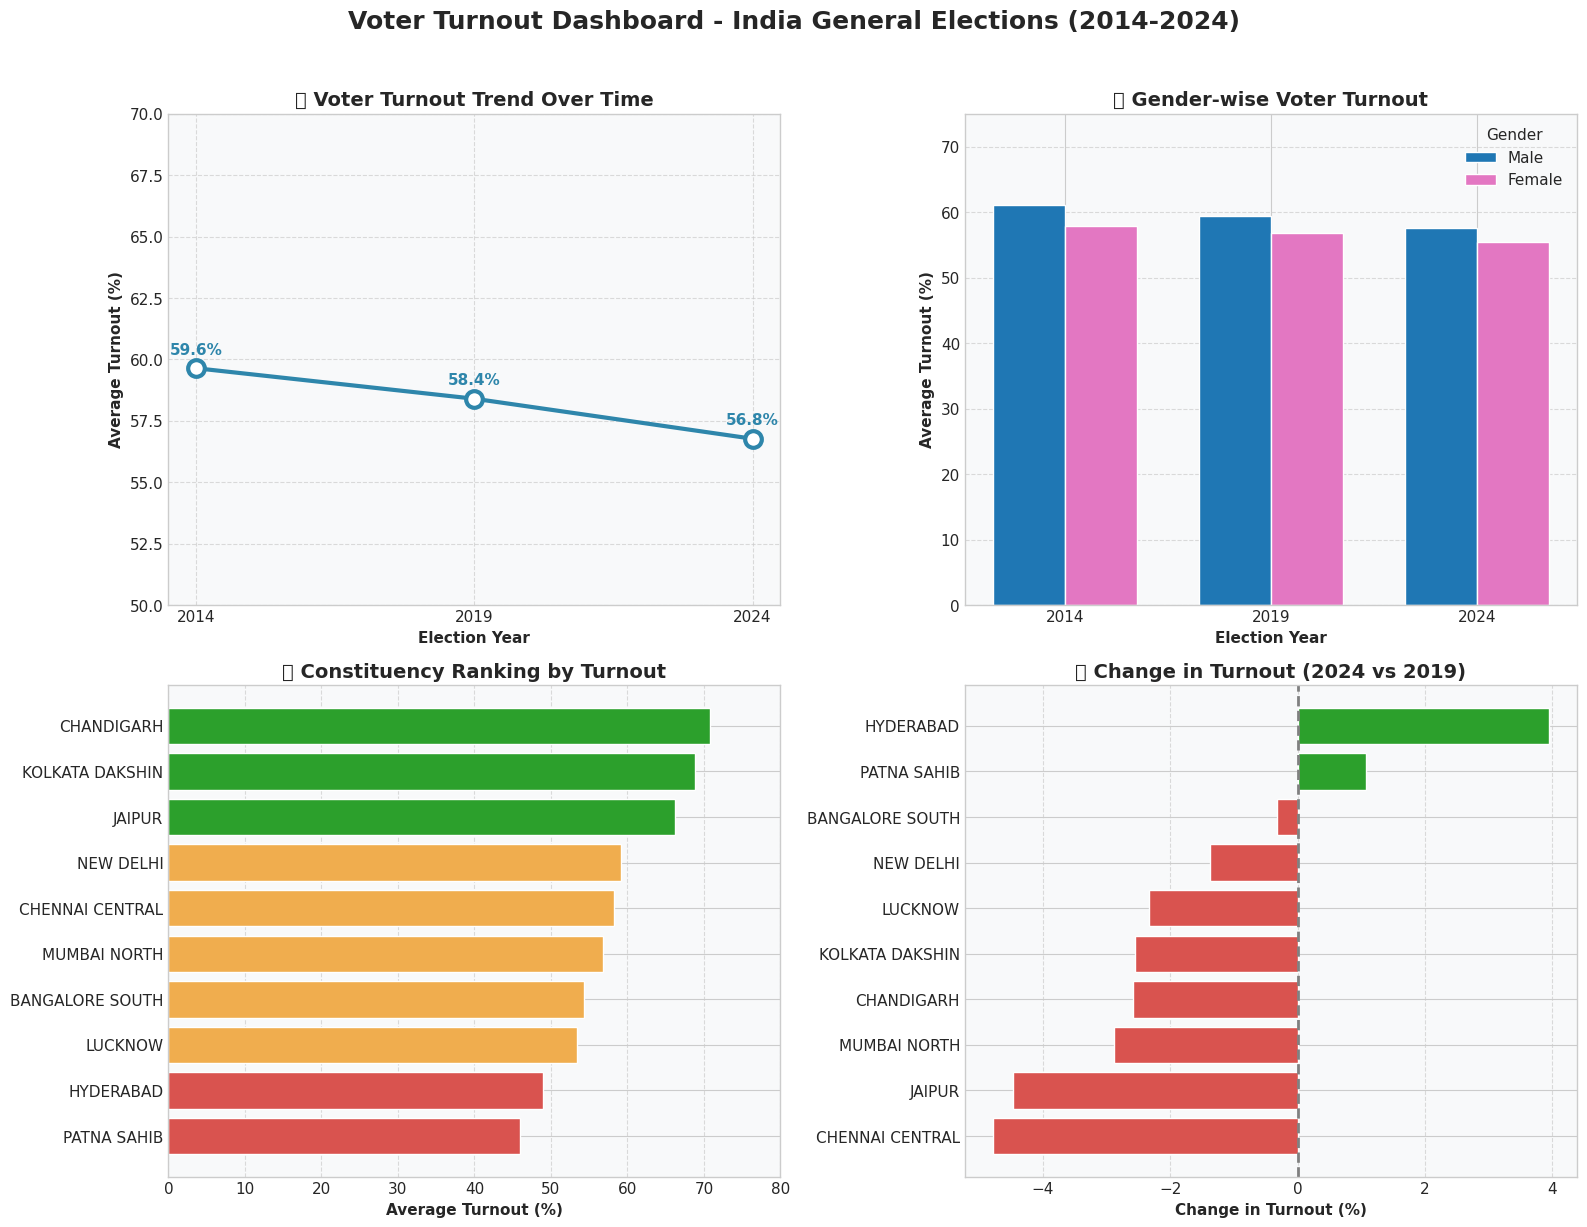


✅ Static dashboard saved to 'cleaned_data/dashboard_static.png'


In [10]:
# ============================================================
# Static Dashboard using Matplotlib (for PDF/Print export)
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Voter Turnout Dashboard - India General Elections (2014-2024)', 
             fontsize=18, fontweight='bold', y=1.02)

# Panel 1: Line Chart - Trend over time
ax1 = axes[0, 0]
yearly_data = df.groupby('Year')['Turnout_Percent'].mean()
ax1.plot(yearly_data.index, yearly_data.values, marker='o', 
         markersize=12, linewidth=3, color='#2E86AB',
         markerfacecolor='white', markeredgewidth=3)
for year, turnout in yearly_data.items():
    ax1.annotate(f'{turnout:.1f}%', xy=(year, turnout), 
                 xytext=(0, 10), textcoords='offset points',
                 ha='center', fontsize=11, fontweight='bold', color='#2E86AB')
ax1.set_title('📈 Voter Turnout Trend Over Time', fontsize=14, fontweight='bold')
ax1.set_xlabel('Election Year', fontweight='bold')
ax1.set_ylabel('Average Turnout (%)', fontweight='bold')
ax1.set_xticks([2014, 2019, 2024])
ax1.set_ylim(50, 70)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_facecolor('#f8f9fa')

# Panel 2: Bar Chart - Gender comparison
ax2 = axes[0, 1]
gender_data = df.groupby('Year').agg({
    'Turnout_Male': 'mean',
    'Turnout_Female': 'mean'
}).reset_index()
x = np.arange(len(gender_data))
width = 0.35
bars1 = ax2.bar(x - width/2, gender_data['Turnout_Male'], width, 
                label='Male', color='#1f77b4', edgecolor='white')
bars2 = ax2.bar(x + width/2, gender_data['Turnout_Female'], width, 
                label='Female', color='#e377c2', edgecolor='white')
ax2.set_title('👥 Gender-wise Voter Turnout', fontsize=14, fontweight='bold')
ax2.set_xlabel('Election Year', fontweight='bold')
ax2.set_ylabel('Average Turnout (%)', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(gender_data['Year'])
ax2.legend(title='Gender')
ax2.set_ylim(0, 75)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.set_facecolor('#f8f9fa')

# Panel 3: Horizontal Bar - Constituency Ranking
ax3 = axes[1, 0]
const_avg = df.groupby('PC_Name')['Turnout_Percent'].mean().sort_values()
colors = ['#2ca02c' if x >= 60 else ('#f0ad4e' if x >= 50 else '#d9534f') 
          for x in const_avg.values]
ax3.barh(const_avg.index, const_avg.values, color=colors, edgecolor='white')
ax3.set_title('🏙️ Constituency Ranking by Turnout', fontsize=14, fontweight='bold')
ax3.set_xlabel('Average Turnout (%)', fontweight='bold')
ax3.set_xlim(0, 80)
ax3.grid(axis='x', linestyle='--', alpha=0.7)
ax3.set_facecolor('#f8f9fa')

# Panel 4: Change Chart
ax4 = axes[1, 1]
pivot_data = df.pivot(index='PC_Name', columns='Year', values='Turnout_Percent')
pivot_data['Change'] = pivot_data[2024] - pivot_data[2019]
pivot_data = pivot_data.sort_values('Change')
colors = ['#2ca02c' if x > 0 else '#d9534f' for x in pivot_data['Change'].values]
ax4.barh(pivot_data.index, pivot_data['Change'], color=colors, edgecolor='white')
ax4.axvline(x=0, color='gray', linestyle='--', linewidth=2)
ax4.set_title('📊 Change in Turnout (2024 vs 2019)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Change in Turnout (%)', fontweight='bold')
ax4.grid(axis='x', linestyle='--', alpha=0.7)
ax4.set_facecolor('#f8f9fa')

plt.tight_layout()
plt.savefig('cleaned_data/dashboard_static.png', dpi=200, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

print("\n✅ Static dashboard saved to 'cleaned_data/dashboard_static.png'")

## 7. Dashboard Design Principles Applied

### Gestalt Principles:
1. **Proximity** - Related charts are grouped together in the 2x2 grid layout
2. **Similarity** - Consistent color coding (green=good, red=needs attention)
3. **Continuity** - Eye follows the natural flow from KPI cards → charts → insights
4. **Figure-Ground** - Clear separation between data visualizations and background
5. **Common Region** - Drill-down section is enclosed in its own visual container

### Visualization Best Practices:
1. **Clear Titles** - Each chart has a descriptive title with emoji for visual interest
2. **Consistent Colors** - Same color palette used across all charts
3. **Interactive Elements** - Hover tooltips provide detailed information
4. **Data Labels** - Key values annotated directly on charts
5. **Appropriate Chart Types** - Line for trends, bar for comparisons, horizontal bar for rankings
6. **Drill-Down Feature** - Dropdown selector allows detailed constituency exploration

### Color Schema:
- **Primary Blue (#2E86AB)** - Main accent color for important data
- **Pink (#e377c2)** - Female data representation
- **Green (#2ca02c)** - Positive change / High performance
- **Red (#d9534f)** - Negative change / Low performance
- **Amber (#f0ad4e)** - Medium performance

### Interactive Features:
- **Main Dashboard**: 4 panels with pan, zoom, hover, reset, save
- **Drill-Down Panel**: Constituency dropdown selector updates detailed charts automatically

In [11]:
# ============================================================
# Final Summary - Assignment Completion Status
# ============================================================

print("=" * 70)
print("📋 ASSIGNMENT COMPLETION SUMMARY")
print("=" * 70)

print("\n✅ TASK 1: Data Creation [5 Marks]")
print("   • Curated dataset with 10 constituencies across 3 election years")
print("   • File: cleaned_data/curated_voter_turnout_10_constituencies.csv")
print("   • Variables: 3 Categorical, 15 Quantitative (Total: 18)")
print("   • Includes: Turnout_Postal (postal vote ratio)")

print("\n✅ TASK 2: Visualization Development [10 Marks]")
print("   • (a) Line Chart: Voter turnout trend over time")
print("   • (b) Grouped Bar: Gender-wise comparison")
print("   • (c) Heatmap: Constituency × Time distribution")
print("   • (d) Interactive Bokeh: Gender turnout by constituency")

print("\n✅ TASK 3: Dashboard Design [5 Marks]")
print("   • KPI Cards with key metrics")
print("   • 4-panel interactive dashboard (Bokeh)")
print("   • ✅ DRILL-DOWN FEATURE: Constituency selector dropdown")
print("   • Static dashboard for export (Matplotlib)")
print("   • Applied Gestalt Principles and visualization best practices")

print("\n" + "=" * 70)
print("📁 OUTPUT FILES GENERATED:")
print("=" * 70)
print("   Data Files:")
print("   • cleaned_data/curated_voter_turnout_10_constituencies.csv")
print("   • cleaned_data/curated_voter_turnout_10_constituencies.xlsx")
print("\n   Visualization Files:")
print("   • cleaned_data/viz_a_turnout_over_time.png")
print("   • cleaned_data/viz_b_turnout_by_gender.png")
print("   • cleaned_data/viz_c_heatmap_constituency_time.png")
print("   • cleaned_data/dashboard_static.png")

print("\n" + "=" * 70)
print("🎓 TOTAL MARKS: 20")
print("=" * 70)

📋 ASSIGNMENT COMPLETION SUMMARY

✅ TASK 1: Data Creation [5 Marks]
   • Curated dataset with 10 constituencies across 3 election years
   • File: cleaned_data/curated_voter_turnout_10_constituencies.csv
   • Variables: 3 Categorical, 15 Quantitative (Total: 18)
   • Includes: Turnout_Postal (postal vote ratio)

✅ TASK 2: Visualization Development [10 Marks]
   • (a) Line Chart: Voter turnout trend over time
   • (b) Grouped Bar: Gender-wise comparison
   • (c) Heatmap: Constituency × Time distribution
   • (d) Interactive Bokeh: Gender turnout by constituency

✅ TASK 3: Dashboard Design [5 Marks]
   • KPI Cards with key metrics
   • 4-panel interactive dashboard (Bokeh)
   • ✅ DRILL-DOWN FEATURE: Constituency selector dropdown
   • Static dashboard for export (Matplotlib)
   • Applied Gestalt Principles and visualization best practices

📁 OUTPUT FILES GENERATED:
   Data Files:
   • cleaned_data/curated_voter_turnout_10_constituencies.csv
   • cleaned_data/curated_voter_turnout_10_const